# Analyze of Dicom files

In [1]:
import os 
import cv2
import pydicom
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [2]:
def store2txt(dicom_file, txtname = "dicom_info"):
    """This function extract and store the metadata in a txt file"""
    with open(f"{txtname}.txt", "w") as f:
        for element in tqdm(dicom_file, desc = "Extraction"):
            f.write(f"{element.tag} - {element.name}: {element.value}\n")

In [3]:
def imshow_dicom(file):
    """Show dicom images"""
    name = os.path.basename(file)
    img = pydicom.dcmread(file)
    arr = img.pixel_array
    plt.title(f"Image: {name}")
    plt.axis("off")
    plt.imshow(arr, cmap = "gray")

```Unfortunately I have found a dicom file without Pixel Data. I think all data have values. We will process a function which can analyzes and return all dicom file with pixel array which can be manipulate```

In [4]:
def check_pixeldata(path, verbose = True):
    """Function used to check if in a dicom file we have Pixel Data"""
    if os.path.isdir(path):
        print("The path provide is a folder")
        ok_path = list()
        notok_path = list()
        for i in tqdm(range(len(os.listdir(path)))):
            f = os.listdir(path)[i]
            f = os.path.join(path, f)
            x = pydicom.dcmread(f)
            if 'PixelData' in x:
                if verbose:
                    print(f"{f} contains pixel values. OK")
                ok_path.append(f)
            else:
                if verbose:
                    print(f"{f} don't provide pixel values!!! Not OK!")
                notok_path.append(f)
        print(f"We have {len(ok_path)} dicom files with pixel values and {len(notok_path)} without pixel values")
        return ok_path, notok_path
    else:
        x = pydicom.dcmread(path)
        if 'PixelData' in x:
            print(f"{path} contains pixel values. OK")
        else:
            print(f"{path} don't provide pixel values!!! Not OK!")

In [5]:
# Annotations images
goodlist, badlist = check_pixeldata(path = "/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/Data/Data/OK_annotations", verbose = False)

The path provide is a folder


100%|██████████| 940/940 [00:06<00:00, 141.28it/s]

We have 904 dicom files with pixel values and 36 without pixel values


In [6]:
# OK images
goodlist_2, badlist_2 = check_pixeldata(path = "/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/Data/Data/OK_images", verbose = False)

The path provide is a folder


100%|██████████| 203/203 [00:01<00:00, 141.55it/s]

We have 189 dicom files with pixel values and 14 without pixel values


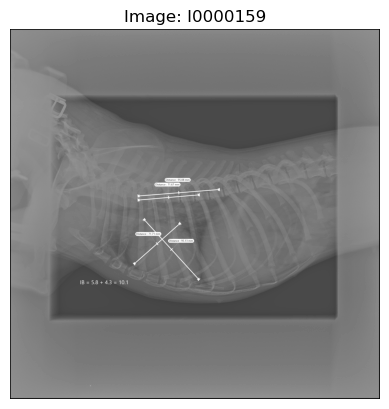

In [7]:
# Test 
imshow_dicom(goodlist[0])

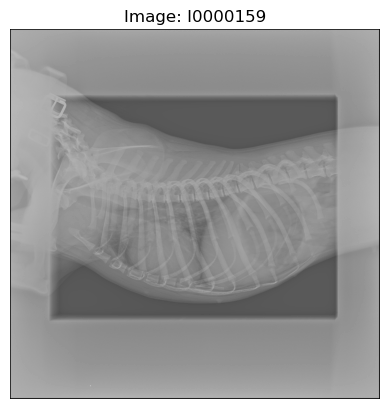

In [8]:
imshow_dicom(goodlist_2[0])

Good good good 

Let's see the metadata contains in this dicom file

In [9]:
store2txt(dicom_file = pydicom.dcmread(goodlist[0]), txtname = "good")
# I have delete the file before push on github

Extraction: 100%|██████████| 131/131 [00:00<00:00, 1425.23it/s]


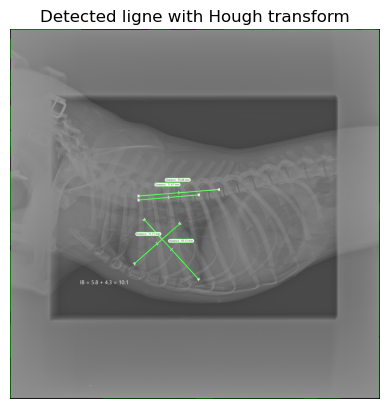

In [10]:
x = pydicom.dcmread(goodlist[0])
x_val = x.pixel_array

if x_val.max() > 255:
    x_val = (x_val / x_val.max()) * 255
x_val = x_val.astype(np.uint8)

edges = cv2.Canny(x_val, 50, 150, apertureSize = 3)
lines = cv2.HoughLinesP(edges, rho = 1, theta = np.pi/180, 
                        threshold = 100, minLineLength = 100, maxLineGap = 10)
image_lines = cv2.cvtColor(x_val, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2) 

plt.imshow(cv2.cvtColor(image_lines, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected ligne with Hough transform")
plt.show()

`The hough transform is not very efficient to detected lines here. 
It's not detecting well and some lines is detected is many sublines.`

Let's think about another approach!

Shape: (1080, 1000)


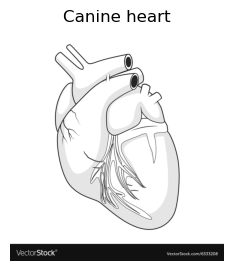

In [11]:
img_heart_path = "saves/images/inputs/heart-of-a-dog.jpg"
img_heart = cv2.imread(img_heart_path)
img_heart = cv2.cvtColor(img_heart, cv2.COLOR_BGR2GRAY)
# Image show
print("Shape: {}".format(img_heart.shape))
plt.figure(figsize = (5,3))
plt.title("Canine heart")
plt.axis('off')
plt.imshow(img_heart, cmap = "gray")
plt.show()

In [12]:
def plot_heart_contour(image, threshold_value = 127, line_color = 'blue', line_style = '--', line_width = 1):
    """
    Detects and plots the contour of a heart shape in an image with a dashed line.
    
    Parameters:
    - image (numpy.darray): image file containing the heart shape.
    - threshold_value (int): The value used for thresholding to create a binary image. Default is 127.
    - line_color (str): The color of the contour line to be plotted. Default is 'blue'.
    - line_style (str): The style of the line for plotting (e.g., '--' for dashed). Default is '--'.
    - line_width (int): The width of the plotted line. Default is 1.
    
    Returns:
    - None: The function displays the plotted image with the detected contour.
    """
    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contour detected in the image.")
    
    contour = max(contours, key=cv2.contourArea)
    x_points = contour[:, 0, 0]  
    y_points = contour[:, 0, 1]
    
    # Plot the image and the contour with a dashed line
    plt.figure(figsize=(5, 3))
    plt.imshow(cv2.cvtColor(img_heart, cv2.COLOR_BGR2RGB))
    plt.plot(x_points, y_points, linestyle=line_style, color=line_color, linewidth=line_width)
    plt.title('Shape of the heart')
    plt.axis('off')
    plt.show()

    return x_points, y_points

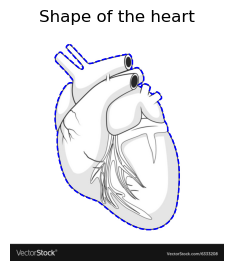

In [13]:
x_points, y_points = plot_heart_contour(img_heart, threshold_value = 127, 
                   line_color = 'blue', line_style = '--', line_width = 1)

To convert pixels to millimeters in an image, it is essential to know the scale factor. This factor can be calculated from the image resolution in DPI (dots per inch), which can be retrieved using libraries like Pillow, using the formula:
$$Scale Factor = \frac{25.4}{DPI}$$
￼
where 25.4 is the number of millimeters in an inch. Once the scale factor is known, converting a measured pixel distance to millimeters is straightforward:
$$Distance = Pixel Distance(pixels) \times Scale Factor(mm/pixels)$$
￼

In medical images formatted as DICOM, the `Pixel Spacing` tag directly provides the distance between adjacent pixels in millimeters, simplifying the conversion. For example, if the Pixel Spacing is 0.14 mm/pixel, it means each pixel represents 0.14 mm. To convert a distance of 200 pixels:
$$Distance = 200 \times 0.14 = 28 mm$$ 
￼

Thus, converting pixels to millimeters provides accurate real-world measurements, which are crucial for analyzing objects such as organs in medical images.

In [14]:
def find_scale_factor(image_path):
    """Find the scale factor of the image"""
    with Image.open(image_path) as img:
        dpi = img.info.get("dpi", (96,96))
        print(f"DPI: {dpi}")
        scale_factor_mm_per_pixel = 25.4 / dpi[0] # 25.4 is the number of millimeters in an inch
        print(f"Scale factor (mm/pixel): {scale_factor_mm_per_pixel:.4f}")
    return scale_factor_mm_per_pixel

def pixels2mm(pixel_distance, scale_factor_mm_per_pixel):
    """Convert pixels to mm"""
    distance_mm = pixel_distance * scale_factor_mm_per_pixel
    return distance_mm

In [15]:
def calculate_heart_diameters(x_points, y_points, img_heart):
    """
    Calculates and plots the major and minor diameters of a shape (e.g., heart) 
    based on the x and y coordinates of the contour points.

    Parameters:
    - x_points (numpy.ndarray): Array of x-coordinates of the contour points.
    - y_points (numpy.ndarray): Array of y-coordinates of the contour points.
    - img_heart (numpy.ndarray): The original image of the heart (in BGR format).

    Returns:
    - max_distance (float): The length of the major diameter in pixels.
    - minor_diameter (float): The length of the minor diameter in pixels.

    Description:
    The function first calculates the major diameter, which is the maximum distance 
    between any two points in the given contour. Then, it calculates the minor diameter 
    as the maximum perpendicular projection distance from the center of the major diameter 
    line to the contour points.

    The function plots the major and minor diameters on the original image with the major 
    diameter in blue and the minor diameter in orange.

    Steps:
    1. Create an array of points by combining `x_points` and `y_points`.
    2. Calculate the major diameter by finding the pair of points with the maximum distance.
    3. Compute the center of the major diameter and its direction vector.
    4. Calculate the minor direction vector perpendicular to the major direction.
    5. Project the contour points onto the minor direction to find the endpoints of 
       the minor diameter.
    6. Plot the major and minor diameters on the image.

    Plot:
    - The image is displayed with the major diameter in blue and the minor diameter in orange.
    - The function returns the lengths of both diameters in pixels.
    """
    points = np.column_stack((x_points, y_points))
    
    # Calculate major diameter
    # Find the two points with maximum distance
    max_distance = 0
    major_p1 = None
    major_p2 = None
    
    for i in tqdm(range(len(points)), desc = "Processing distances"):
        for j in range(i + 1, len(points)):
            dist = np.sqrt(np.sum((points[i] - points[j])**2))
            if dist > max_distance:
                max_distance = dist
                major_p1 = points[i]
                major_p2 = points[j]
    
    center = (major_p1 + major_p2) / 2
    major_direction = major_p2 - major_p1
    major_direction = major_direction / np.linalg.norm(major_direction)
    
    minor_direction = np.array([-major_direction[1], major_direction[0]])
    projections = np.abs(np.dot(points - center, minor_direction))
    minor_radius = np.max(projections)
    proj_distances = np.dot(points - center, minor_direction)
    minor_p1 = center + minor_direction * np.min(proj_distances)
    minor_p2 = center + minor_direction * np.max(proj_distances)
    
    # Plot the results
    plt.figure(figsize=(5, 3))
    plt.imshow(cv2.cvtColor(img_heart, cv2.COLOR_BGR2RGB))
    #plt.plot(x_points, y_points, linestyle='--', color='blue', linewidth=1)
    plt.plot([major_p1[0], major_p2[0]], [major_p1[1], major_p2[1]], 
             color='blue', linewidth=1, label=f'Major Diameter: {max_distance:.1f} pixels')
    plt.plot([minor_p1[0], minor_p2[0]], [minor_p1[1], minor_p2[1]], 
             color='orange', linewidth=1, label=f'Minor Diameter: {minor_radius*2:.1f} pixels')
    
    plt.title('Heart Diameters Analysis')
    #plt.legend()
    plt.axis('off')
    plt.show()
    
    return max_distance, minor_radius*2

Processing distances: 100%|██████████| 1185/1185 [00:01<00:00, 637.91it/s] 


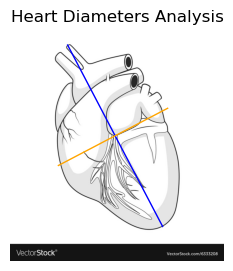

DPI: (72, 72)
Scale factor (mm/pixel): 0.3528
Major diameter: 337.68 mm
Minor diameter: 211.21 mm


In [16]:
major_diameter, minor_diameter = calculate_heart_diameters(x_points, y_points, img_heart)
scale_factor_mm_per_pixel = find_scale_factor(img_heart_path)
print(f"Major diameter: {major_diameter * scale_factor_mm_per_pixel:.2f} mm")
print(f"Minor diameter: {minor_diameter * scale_factor_mm_per_pixel:.2f} mm")

In [17]:
x = pydicom.dcmread(goodlist_2[0])
scale_factor = x.PixelSpacing
print(f"Scale Factor = {scale_factor}")
print(f"It means that each pixel represents {scale_factor[0]} mm in both horizontal and vertical directions")

Scale Factor = [0.14, 0.14]
It means that each pixel represents 0.14 mm in both horizontal and vertical directions
